# One-Dimensional Climate Models: Brown Dwarfs w/ Clouds in Chemical Disequilibrium

In this tutorial you will learn how to run 1-D climate models for brown dwarfs with Virga clouds and chemical disequilibrium 

You should already be familiar with running 1-D climate models with running a [simple clear brown dwarf model](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html) and running clouds in [equilibrium]() 

What you need to have downloaded for clouds to work: 
[Virga](https://natashabatalha.github.io/virga/installation.html)


In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import virga.justdoit as vj
import virga.justplotit as cldplt
jpi.output_notebook()
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import show, figure
import xarray
import pickle

Loading BokehJS ...

In [2]:
#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

ck_db = f'/data/kcoeff_2020_v3/sonora_2020_feh{mh}_co_{CtoO}.data.196'
#sonora bobcat cloud free structures file
sonora_profile_db = '/data/sonora_bobcat/structure/structures_m+0.0'
sonora_profile_db = '/Users/nbatalh1/Documents/data/sonora_bobcat/structures_m+0.0'

We are going to initialize our climate run exactly like every other climate run here

In [3]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation

teff= 400 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

gases_fly = ['CO','CH4','H2O','NH3','CO2','N2','HCN','H2','PH3','C2H2','Na','K','TiO','VO','FeH']
opacity_ck =  jdi.opannection(method='resortrebin',preload_gases=gases_fly)# grab your opacities

In [4]:
nlevel = 91 # number of plane-parallel levels in your code

# Here we're going to start with a cloudfree Sonora Elf Owl model
pressure,temp_guess = np.loadtxt("profilegrid_kz_1d9_qt_onfly_400_grav_1000_mh_+0.0_cto_1.0.dat",
                                usecols=[1,2],unpack=True, skiprows = 1)

In [5]:
nofczns = 1 # number of convective zones initially

nstr_upper = 45 # top most level of guessed convective zone 
# for the sake of time of this tutorial, I set it to 40 because I know where it should be in this case. In general for clouds it is better
# to start deeper in the atmosphere and work your way up. It just takes more time.

nstr_deep = nlevel - 2 # this is always the case. Dont change this
# nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # single convective zone

nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

# this is the Kzz parameter
kzval = pressure*0+1e9

In [6]:
virga_dir = '//Users/nbatalh1/Documents/data/virga' # path to virga directory with the Mie scatering files

All requirements needed for this notebook will be met from properly following the previous notebook for clouds in equilibrium chemistry

**New PICASO code parameters**: 
These are all optional

1. `deq_rainout` : (True/False) Follows rainout chemistry (ie. Sonora Bobcat) even in disequilibrium. Default = False
2. `quench_ph3` : (True/False) If False, PH3 will follow equilibrium chemistry table abundances. Default = False
3. `kinetic_CO2` : (True/False) If True, will follow kinetic CO2 prescription described in [Zahnle & Marley 2014](https://iopscience.iop.org/article/10.1088/0004-637X/797/1/41) where the abundance quenches with respect to CO in disequilibrium. Default = False
4. `no_ph3` :  (True/False) If True, completely remove PH3 from the atmosphere. Default = False

These parameters are included to increase flexibility for you when you want to generate your own model! Our recommendation to follow for the latest release of the Sonora family of models are as follows:

1. `deq_rainout` = True
2. `quench_ph3` = False
3. `kinetic_CO2` = True
4. `no_ph3` = True

In [ ]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)

cl_run.atmosphere(mh=1, cto_relative=1, chem_method='visscher',
                quench=True, cold_trap = True, no_ph3 = True, vol_rainout=True)# 

cl_run.inputs['atmosphere']['profile']['kz']=kzval

df_cld_guess=cl_run.virga(condensates=['Cr', 'MnS', 'Na2S', 'ZnS', 'KCl'], fsed=2.0, directory=virga_dir)

In this case, with a good starting radiative-convective boundary guess and a good starting PT profile, this run should take ~10 minutes to compute. If it takes significantly longer longer there might be something wrong. Most times though, cloudy runs do take much longer on timescales of 30 minutes to an hour depending on how deep your intial radiaitve-convective zone boundary is.

In [8]:
out = cl_run.climate(opacity_ck, save_all_profiles = True, with_spec=True,
        diseq_chem = True, self_consistent_kzz =False)

SUMMARY
-------
Clouds: True
quench True
cold_trap True
vol_rainout True
no_ph3 True
Moist Adiabat: False
[ 1.3 -1.   1.5 -0.3  0.7  0.  -0.5  1.   1.7  0.3  2.  -0.7  0.5]
[0.687 0.137 0.961 0.824 0.549 0.412 0.275]
cold_trap=True; Adjusting cold trap for ['Cr', 'MnS', 'Na2S', 'ZnS', 'KCl']
no_ph3=True; Goodbye PH3!
Computed quenched levels at {'CO-CH4-H2O': np.int64(74), 'CO2': np.int64(67), 'NH3-N2': np.int64(75), 'HCN': np.int64(73), 'PH3': np.int64(72)}
[ 1.3 -1.   1.5 -0.3  0.7  0.  -0.5  1.   1.7  0.3  2.  -0.7  0.5]
[0.687 0.137 0.961 0.824 0.549 0.412 0.275]
Quench=True; Adjusting quench chemistry
vol_rainout=True; Adjusting volatile rainout for ['Cr', 'MnS', 'Na2S', 'ZnS', 'KCl']
cold_trap=True; Adjusting cold trap for ['Cr', 'MnS', 'Na2S', 'ZnS', 'KCl']
no_ph3=True; Goodbye PH3!
Doing clouds: Max TAUCLD diff is 0.23170602217635586  Tau tolerance is  0.04634120443527118
Iteration number  0 , min , max temp  97.17399107248211 3475.2995888485043 , flux balance  -0.0090766275308

## Plot the P-T Profile

Now we can plot the results, first let's grab the condensation curve for all our cloud species

In [11]:
kcl_cond_p, kcl_cond_t = vj.condensation_t('KCl', 1, 2.2, pressure = out['pressure'])
na2s_cond_p, na2s_cond_t = vj.condensation_t('Na2S', 1, 2.2, pressure = out['pressure'])
mns_cond_p, mns_cond_t = vj.condensation_t('MnS', 1, 2.2, pressure = out['pressure'])
zns_cond_p, zns_cond_t = vj.condensation_t('ZnS', 1, 2.2, pressure = out['pressure'])
cr_cond_p, cr_cond_t = vj.condensation_t('Cr', 1, 2.2, pressure = out['pressure'])

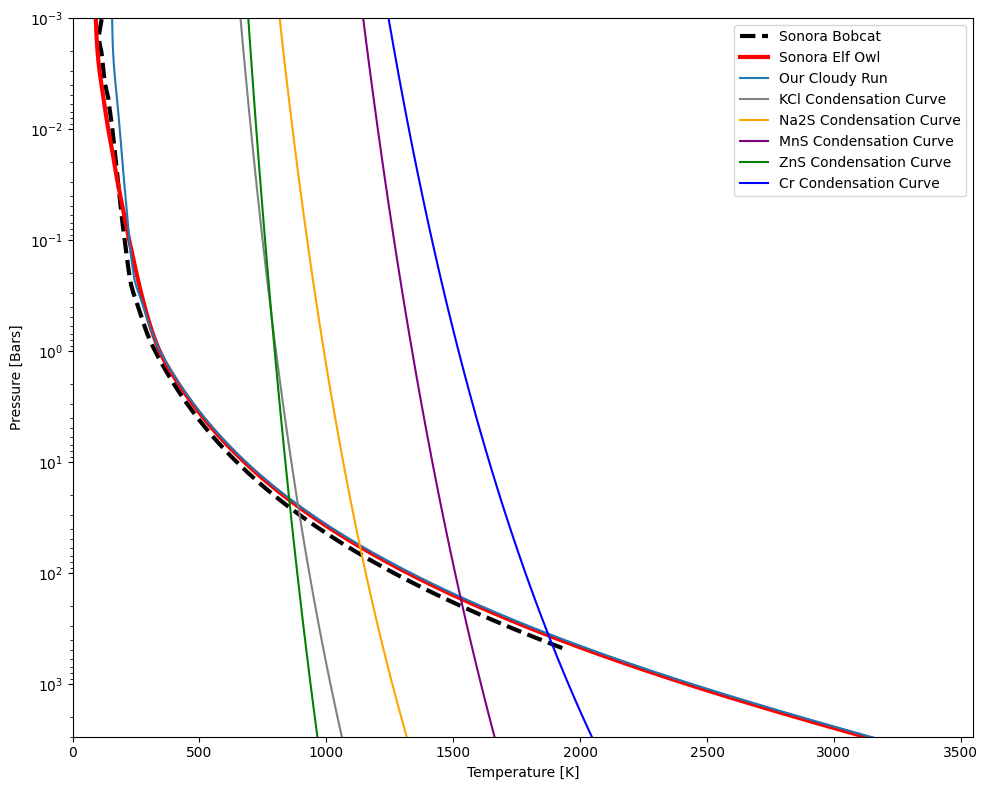

In [12]:
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)

pressure_elfowl,temp_elfowl = np.loadtxt(f"profilegrid_kz_1d9_qt_onfly_400_grav_1000_mh_+0.0_cto_1.0.dat",
                                usecols=[1,2],unpack=True, skiprows = 1)

plt.figure(figsize=(10,8))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
plt.xlim(0,max(out['temperature'])+50)
plt.ylim(3e3,1e-3)

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")
plt.semilogy(temp_elfowl,pressure_elfowl,color='r',linewidth=3, label="Sonora Elf Owl")
plt.semilogy(out['temperature'],out['pressure'],label="Our Cloudy Run")

plt.plot(kcl_cond_t,kcl_cond_p, color ='gray', label = 'KCl Condensation Curve')
plt.plot(na2s_cond_t,na2s_cond_p, color ='orange', label = 'Na2S Condensation Curve')
plt.plot(mns_cond_t,mns_cond_p, color ='purple', label = 'MnS Condensation Curve')
plt.plot(zns_cond_t,zns_cond_p, color ='green', label = 'ZnS Condensation Curve')
plt.plot(cr_cond_t,cr_cond_p, color ='blue', label = 'Cr Condensation Curve')

plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# once again we can do a quick sanity check to make sure a cloud is present
show(jpi.mixing_ratio(out['spectrum_output']['full_output'], limit=14, height=600, width=600))

In [14]:
# once again we can do a quick sanity check to make sure a cloud is present
show(cldplt.all_optics_1d(out['virga_output'], wave_range=[1,2]))

## Cloudy vs Clear Spectra

In [17]:
opa_mon = jdi.opannection(wave_range=[0.3,15])

hi_res = jdi.inputs(calculation="browndwarf") # start a calculation
teff= 400 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s
hi_res.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity

hi_res.atmosphere(df=out['ptchem_df'])

# now let's add the cloud optical properties
hi_res.clouds(df=out['cld_df'])

df_spec = hi_res.spectrum(opa_mon, calculation='thermal',full_output=True)

wno, fp = df_spec['wavenumber'], df_spec['thermal'] #erg/cm2/s/cm
wno,fp = jdi.mean_regrid(wno,fp, R =200)

In [18]:
jpi.show(jpi.spectrum(wno,fp,x_axis_type='log',y_axis_type='log'))

This next spectrum is from the Sonora Elf Owl grid of models which are cloud-free to use as reference. To download the rest of the Sonora Elf Owl grid you can find them separated by [L](https://zenodo.org/records/10385987), [T](https://zenodo.org/records/10385821), and [Y](https://zenodo.org/records/10381250) dwarfs.

In [19]:
ds_elfowl = xarray.load_dataset("spectra_logzz_9.0_teff_400.0_grav_1000.0_mh_0.0_co_1.0.nc")

Now let's regrid the spectra to R=200 to make sure the two spectra are on the same grid

In [21]:
wno_elfowl, fp_elfowl = jdi.mean_regrid(1e4/ds_elfowl['wavelength'].values,ds_elfowl['flux'].values,R=200)

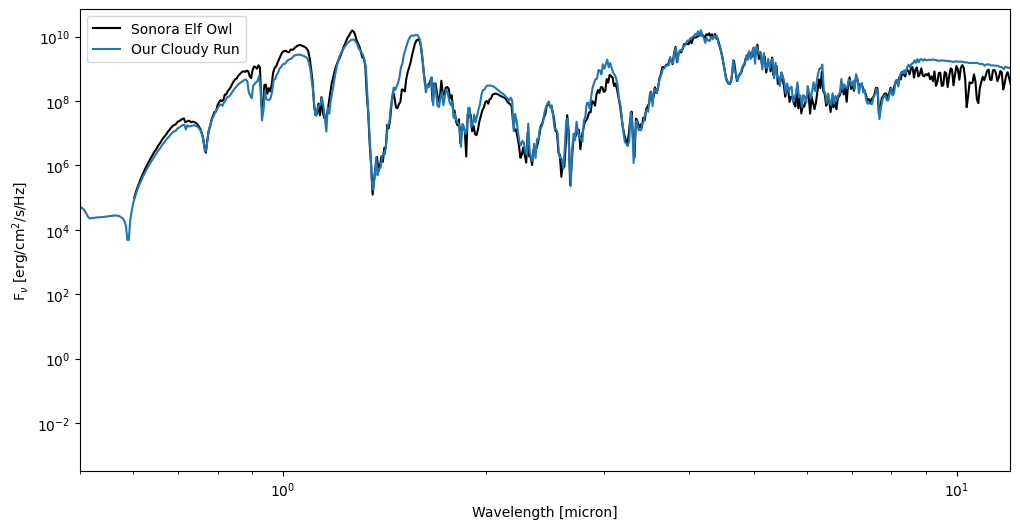

In [22]:
fig = plt.figure(figsize=(12,6))
plt.loglog(1e4/wno_elfowl,fp_elfowl, 'k', label = 'Sonora Elf Owl')
plt.loglog(1e4/wno,fp, label = 'Our Cloudy Run')
plt.xlabel('Wavelength [micron]')
plt.ylabel('F$_\\nu$ [erg/cm$^2$/s/Hz]')
plt.xlim(0.5,12)
plt.legend()
plt.show()

For these cloud species you can see their features in the Y and J bands for example in comparison to the cloud-free Sonora Elf Owl model